In [304]:
import pandas as pd
from isbtchot.model import btc_hist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

In [305]:
df = btc_hist()[["Close"]].rename({"Close":"price"}, axis=1)
YEARS_PREDICTION = 20

# Adjust for genesis block
GENESIS_DELTA = (df.index[0] - pd.Timestamp(year=2009, month=1, day=3)).days
df["days"] = np.arange(len(df)) + GENESIS_DELTA



In [306]:
# Applying log transformation
X_log = np.log(df['days'].values.reshape(-1, 1))
y_log = np.log(df['price'].values)

# Fit the linear regression model on the log-transformed data
power_law_model = LinearRegression().fit(X_log, y_log)

# The coefficient 'b' is the slope of the line in the log-log space
b = power_law_model.coef_[0]
# The coefficient 'a' is obtained by taking the exponential of the intercept in the log-log space
a = np.exp(power_law_model.intercept_)

# Print the model
a, b

(2.7429700692394034e-17, 5.706434941611239)

In [307]:
periods = 365 * YEARS_PREDICTION
df = pd.concat([df, pd.DataFrame(
    {
        "days": np.arange(periods) + df.days.iloc[-1],
    },
    index=pd.date_range(df.index[-1], periods=periods, freq="D")
)])

In [308]:
# Using the power law model to predict prices across the original range of days
df['power_law'] = a * (df['days'] ** b)
df['power_law_bottom'] = df['power_law'] * 0.45
df['power_law_top'] = df['power_law'] * 3
df["delta"] = df.price / df.power_law

In [309]:
# Assuming btc_hist() and other necessary imports are already defined

# Constants for the sinusoidal component
PERIOD = 3.8 * 365  # 4 years in days
AMPLITUDE = 8  # Adjust this based on the amplitude of the first bubble
PHASE_SHIFT = -120  # Adjust based on alignment with the first bubble's peak

# Constants for the exponential decay
LIFESPAN = 3  # Number of observed bubbles
DECAY_RATE = 0.2 # Observed decay rate, adjust based on your observations

# Adding the sinusoidal component
df['sinusoidal'] = AMPLITUDE * np.sin(2 * np.pi * (df['days'] / PERIOD) + PHASE_SHIFT)

# Adding the exponential decay component
# Assuming a linear decay for simplicity, adjust as needed for your model
df['decay'] = np.exp(-DECAY_RATE * (df['days'] / (LIFESPAN * 365)))

# Combining the components to get the adjusted price
# Note: Adjust the formula as per your model specifics and scaling needs
df['adjusted_price'] = a * (df['days'] ** b) * df['sinusoidal'] * df['decay']
df['final_price'] = np.maximum(df['adjusted_price'], df['power_law_bottom'])

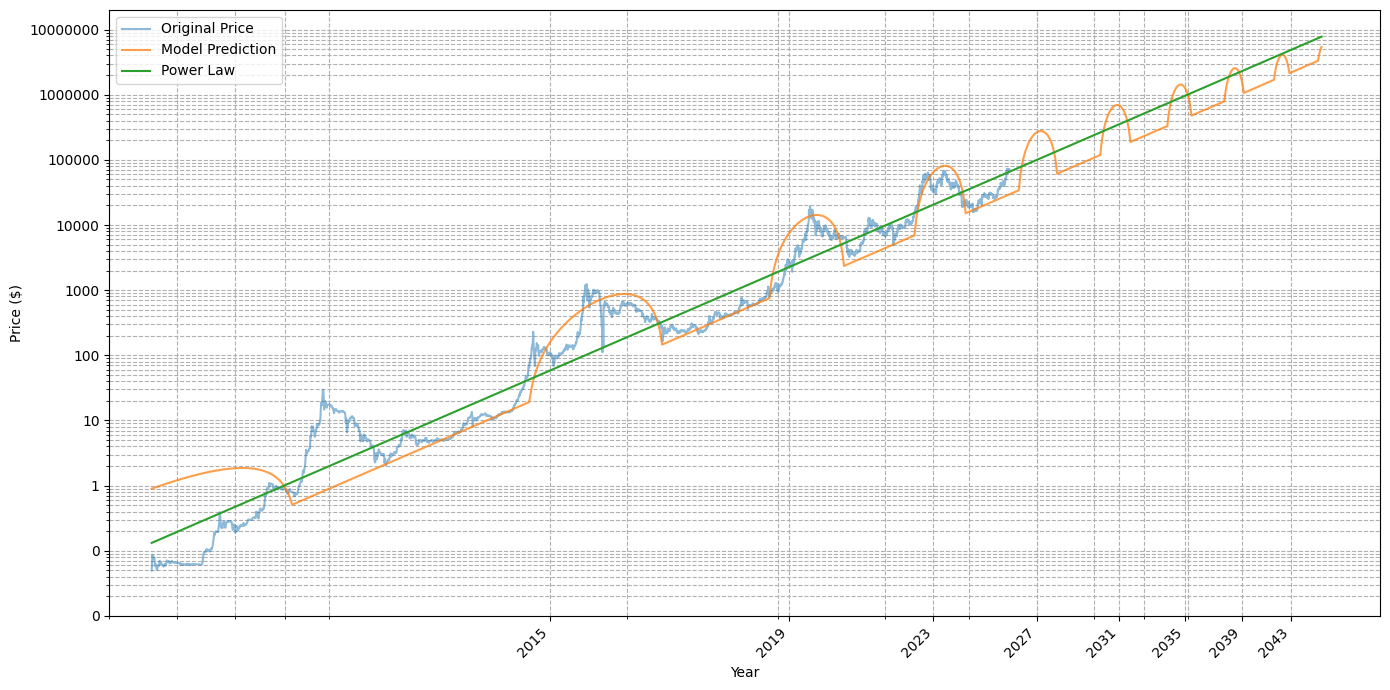

In [310]:
plt.figure(figsize=(14, 7))

plt.plot(df['days'], df['price'], label='Original Price', alpha=0.5)
plt.plot(df['days'], df['final_price'], label='Model Prediction', alpha=0.75)
plt.plot(df['days'], df['power_law'], label='Power Law')

# Setting log scale for both x and y axis
plt.xscale('log')
plt.yscale('log')

# Find the date range
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='4YS')

# Calculate the number of days since the start for each year start
xticks_yearly = [(date - df.index.min()).days for date in date_range]

# Generate yearly labels from the date_range
xticklabels_yearly = [date.strftime('%Y') for date in date_range]

# Setting ticks on the x-axis to correspond to the start of each year
plt.xticks(ticks=xticks_yearly, labels=xticklabels_yearly, rotation=45, ha='right')

# Setting the axis labels
plt.xlabel('Year')
plt.ylabel('Price ($)')

# Set the formatter for the y-axis to plain (no scientific notation)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.gca().yaxis.set_minor_formatter(NullFormatter())

# Adding legend and grid
plt.legend()
plt.grid(True, which="both", ls="--")

# Adding limits
plt.xlim(left=500)
plt.ylim(bottom=0.01)

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()